<a href="https://colab.research.google.com/github/conwayjw97/Image-Colourisation-with-Deep-Learning/blob/master/src/DCNN_Hyperparameter_Optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
IMAGE_COUNT = 50000
TRAINING_IMAGE = 0
TEST_IMAGE = 0
BATCH_SIZE = 1024
CLASSIFICATION_EPOCHS = 1000
COLOURISATION_EPOCHS = 300
LOAD_COLOURISATION_MODEL = False
INPUT_IMAGE = 10

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import math
import time
from scipy.ndimage.filters import gaussian_filter1d
from tensorflow.keras import layers, models, backend, utils, optimizers, regularizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [0]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0

class_train_indices = np.argwhere(train_labels == 0)
train_images = train_images[class_train_indices[:,0]]
train_labels = train_labels[class_train_indices[:,0]]
class_test_indices = np.argwhere(test_labels == 0)
test_images = test_images[class_test_indices[:,0]]
test_labels = test_labels[class_test_indices[:,0]]


output_count = 12
index_offset = 20

train_yuv  = tf.image.rgb_to_yuv(train_images)
train_y = tf.expand_dims(train_yuv[:,:,:,0], 3)
train_uv = train_yuv[:,:,:,1:]

test_yuv = tf.image.rgb_to_yuv(test_images)
test_y = tf.expand_dims(test_yuv[:,:,:,0], 3)
test_uv = test_yuv[:,:,:,1:]

In [0]:
def create_model_very_shallow():
  model = models.Sequential()
  model.add(layers.Conv2D(8, (2, 2), activation='relu', input_shape=(32, 32, 1)))
  model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(16, (3, 3), activation='tanh', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
  return model

In [0]:
def train_image_loader_augmented(x_train, y_train, batch_size):
  datagen = ImageDataGenerator(horizontal_flip=True, rotation_range=60, width_shift_range=0.2, height_shift_range=0.2, brightness_range=(0.5, 1.0), zoom_range=[0.5, 1.5])
  # datagen = ImageDataGenerator()
  datagen.fit(x_train)
  # Keras needs the generator to loop infinitely
  while True:
    for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=batch_size):
      print("\ncount: ", count, " - x_batch.shape: ", x_batch.shape, " - y_batch.shape: ", y_batch.shape)
      yield (x_batch, y_batch)  

def train_image_loader(x_train, y_train, batch_size):
  datagen = ImageDataGenerator()
  datagen.fit(x_train)
  # Keras needs the generator to loop infinitely
  while True:
    for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=batch_size):
      print("\ncount: ", count, " - x_batch.shape: ", x_batch.shape, " - y_batch.shape: ", y_batch.shape)
      yield (x_batch, y_batch)  

def test_image_loader(x_test, y_test, batch_size):
  datagen = ImageDataGenerator()
  # Keras needs the generator to loop infinitely
  while True:
    for x_batch, y_batch in datagen.flow(x_test, y_test, batch_size=batch_size):
      yield (x_batch, y_batch)  

total_loss = []
total_val_loss = []
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, rotation_range=60)
# datagen = ImageDataGenerator(horizontal_flip=True, rotation_range=60, width_shift_range=0.2, height_shift_range=0.2, brightness_range=(0.5, 1.0), zoom_range=[0.5, 1.5])
train_iterator = datagen.flow(train_y, train_uv, batch_size=BATCH_SIZE)

learning_rates = [0.00001, 0.0001, 0.001]
momentums = [0.0, 0.3, 0.6, 0.1]
regularisations = [0.0000001, 0.000001, 0.00001]
dropouts = [0.0, 0.25, 0.5]

results = []
val_results = []
for momentum in momentums:
  start = time.time()
  model = create_basic_final_colourisation_model(0.001, momentum, 0, 0, "SGD")
  history = model.fit_generator(train_iterator, steps_per_epoch=int(train_yuv.shape[0]/BATCH_SIZE), epochs=COLOURISATION_EPOCHS, validation_data=(test_y, test_uv), validation_steps=int(test_yuv.shape[0]/BATCH_SIZE), verbose=1)
  results.append(history.history["loss"])
  val_results.append(history.history["val_loss"])
  print("Total time taken:", time.time()-start)

for momentum in momentums:
  start = time.time()
  model = create_basic_final_colourisation_model(0.001, momentum, 0, 0, "RMSProp")
  history = model.fit_generator(train_iterator, steps_per_epoch=int(train_yuv.shape[0]/BATCH_SIZE), epochs=COLOURISATION_EPOCHS, validation_data=(test_y, test_uv), validation_steps=int(test_yuv.shape[0]/BATCH_SIZE), verbose=1)
  results.append(history.history["loss"])
  val_results.append(history.history["val_loss"])
  print("Total time taken:", time.time()-start)

  ...
    to  
  ['...']
Train for 4 steps, validate on 1000 samples
Epoch 1/300
4/4 [==============================] - 2s 405ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 2/300
4/4 [==============================] - 1s 277ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 3/300
4/4 [==============================] - 1s 287ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 4/300
4/4 [==============================] - 1s 296ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 5/300
4/4 [==============================] - 1s 286ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 6/300
4/4 [==============================] - 1s 295ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 7/300
4/4 [==============================] - 1s 292ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 8/300
4/4 [==============================] - 1s 286ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 9/300
4/4 [==============================] - 1s 286ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 10/300
4/4 [======================

In [0]:
# learning_rates.append(0.01)
# learning_rates.append(0.05)

# start = time.time()
# model = create_basic_final_colourisation_model(lr, 0.0)
# history = model.fit_generator(train_iterator, steps_per_epoch=int(train_yuv.shape[0]/BATCH_SIZE), epochs=COLOURISATION_EPOCHS, validation_data=(test_y, test_uv), validation_steps=int(test_yuv.shape[0]/BATCH_SIZE), verbose=1)
# results.append(history.history["loss"])
# print("Total time taken:", time.time()-start)

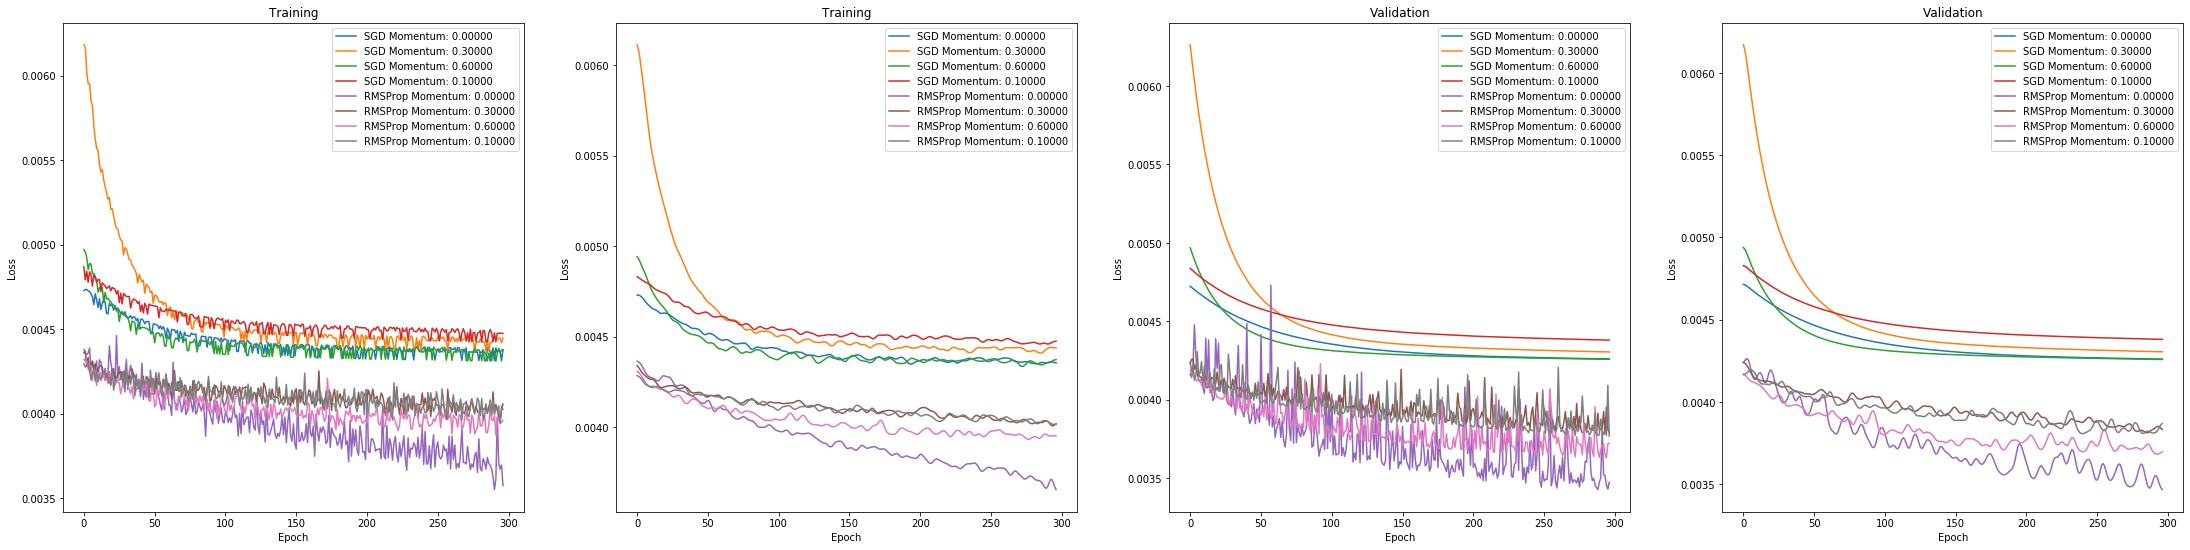

In [0]:
fig = plt.figure(figsize=(38, 9))
ax = fig.add_subplot(1,4,1)
# ax.set_ylim([0.0025,0.005])
for i in range(0, len(momentums)):
  plt.plot(results[i][3:], label="SGD Momentum: %.5f" % (momentums[i]))
for i in range(len(momentums), (len(momentums)*2)):
  plt.plot(results[i][3:], label="RMSProp Momentum: %.5f" % (momentums[i-4]))
plt.title('Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("Fidelity.png")

ax = fig.add_subplot(1,4,2)
# ax.set_ylim([0.0025,0.005])
for i in range(0, len(momentums)):
  plt.plot(gaussian_filter1d(results[i][3:], sigma=2), label="SGD Momentum: %.5f" % (momentums[i]))
for i in range(len(momentums), len(momentums)*2):
  plt.plot(gaussian_filter1d(results[i][3:], sigma=2), label="RMSProp Momentum: %.5f" % (momentums[i-4]))
plt.title('Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("Fidelity.png")

ax = fig.add_subplot(1,4,3)
# ax.set_ylim([0.0025,0.005])
for i in range(0, len(momentums)):
  plt.plot(val_results[i][3:], label="SGD Momentum: %.5f" % (momentums[i]))
for i in range(len(momentums), len(momentums)*2):
  plt.plot(val_results[i][3:], label="RMSProp Momentum: %.5f" % (momentums[i-4]))
plt.title('Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("Fidelity.png")

ax = fig.add_subplot(1,4,4)
# ax.set_ylim([0.0025,0.005])
for i in range(0, len(momentums)):
  plt.plot(gaussian_filter1d(val_results[i][3:], sigma=2), label="SGD Momentum: %.5f" % (momentums[i]))
for i in range(len(momentums), len(momentums)*2):
  plt.plot(gaussian_filter1d(val_results[i][3:], sigma=2), label="RMSProp Momentum: %.5f" % (momentums[i-4]))
plt.title('Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("Smooted.png")

In [0]:
print(results)